# Dirty Modelling

This notebook was created on the purpose of examining reactions of dirty dataset on some learning algorithms to be conscious of possible problems tend to appear, points open for improvement and maybe to find a reference learning method to monitorize future improvements.

Algorithms is either not tuned or broadly tuned only parameters related to imbalanced data if possible

In [1]:
import os
import gc
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

In [2]:
def prepare_dirty_data():   # Some algorithms need huge amount of size of memory so deleting base dataset helps
                            # 

    dtypes = {
    'ProductCD':         'object',
    'card1':             'object',
    'card2':             'object',
    'card3':             'object',
    'card4':             'object',
    'card5':             'object',
    'card6':             'object',
    'addr1':             'object',
    'addr2':             'object',
    'dist1':             'object',
    'dist2':             'object',
    'P_emaildomain':     'object',
    'R_emaildomain':     'object',
    'M1':                'object',
    'M2':                'object',
    'M3':                'object',
    'M4':                'object',
    'M5':                'object',
    'M6':                'object',
    'M7':                'object',
    'M8':                'object',
    'M9':                'object',
    'dist1':             'float64',
    'dist2':             'float64'
    }
    df_train = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv', dtype=dtypes)
    df_train.dropna(axis=1, thresh=df_train.shape[0]*0.95, inplace=True)

    feature_num = list(filter(lambda x: str(df_train[x].dtype) != 'object', df_train.columns ))
    feature_cat = list(filter(lambda x: str(df_train[x].dtype) == 'object', df_train.columns ))

    for feat in feature_cat:
        df_train[feat].replace(to_replace=np.nan, value='Other', inplace=True)

    df_train.dropna(inplace=True)
    print('# of missing :', df_train.isna().sum().sum())

    feature_num = list(filter(lambda x: str(df_train[x].dtype) != 'object', df_train.columns ))
    feature_cat = list(filter(lambda x: str(df_train[x].dtype) == 'object', df_train.columns ))

    df_train.drop('card1', axis=1, inplace = True) # 13500 unique
    df_train.drop('TransactionID', axis=1, inplace=True)
    df_train.drop('TransactionDT', axis=1, inplace=True)
    print(df_train.shape)
    return df_train

In [3]:
def auc_plot_score(model_pred_fn, X_train, X_test, y_train, y_test, dim=2): # Function to take a shortcut of printing plots and 
                                                                            # scores of auc for both train and test sets
    import matplotlib.pyplot as plt
    from sklearn.metrics import auc, roc_curve
    %matplotlib inline
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    fig.suptitle('AUC Plots', fontsize=20)
    
    if dim == 1:
        proba_train = model_pred_fn(X_train)
        proba_test  = model_pred_fn(X_test)
    elif dim == 2:
        proba_train = model_pred_fn(X_train)[:,1]
        proba_test  = model_pred_fn(X_test)[:,1]
        
    fpr_train, tpr_train, _ = roc_curve(y_train, proba_train, pos_label=1, drop_intermediate=False)
    auc_train = round(auc(fpr_train, tpr_train),5)
    
    fpr_test,  tpr_test , _ = roc_curve(y_test , proba_test,  pos_label=1, drop_intermediate=False)
    auc_test = round(auc(fpr_test, tpr_test), 5)
    
    axs[0].plot([0, 1], [0, 1], linestyle='--')
    axs[0].plot(fpr_train, tpr_train, marker='.')
    axs[0].set_title('Train')
    axs[0].set_xlabel(auc_train, fontsize=15)
    
    axs[1].plot([0, 1], [0, 1], linestyle='--')
    axs[1].plot(fpr_test, tpr_test, marker='.')
    axs[1].set_title('Test')
    axs[1].set_xlabel(auc_test, fontsize=15)
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
    
    print(f'Train-set AUC Score = {auc_train}\nTest-set AUC Score = {auc_test}')

### Data Preparing I

In [4]:
X = prepare_dirty_data()

y = X.isFraud.copy()
X = pd.get_dummies(X.drop('isFraud', axis=1, inplace=False), prefix_sep='_', drop_first=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3) 
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

# of missing : 0
(589099, 109)


((412369, 853), (412369,), (176730, 853), (176730,))

### XGBoost

In [5]:
from xgboost import XGBClassifier 

XGBoost = XGBClassifier(max_delta_step=8 , max_depth=9, random_state=42) # max_delta_step 
gc.collect()

18

In [6]:
%%time
XGBoost.fit(X_train, y_train)

CPU times: user 45min 32s, sys: 13.2 s, total: 45min 46s
Wall time: 45min 46s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=8, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

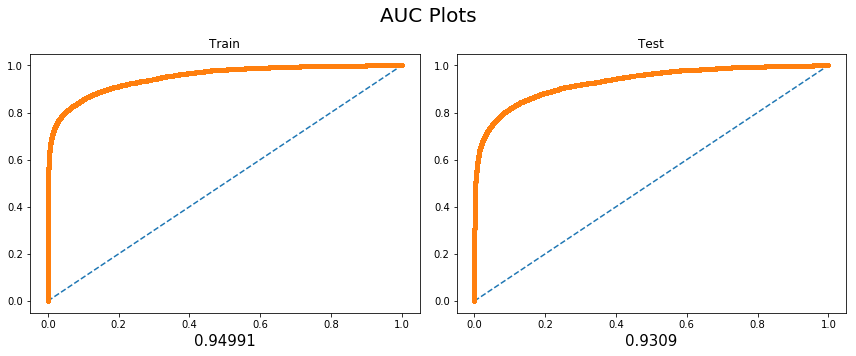

Train-set AUC Score = 0.94991
Test-set AUC Score = 0.9309


In [7]:
auc_plot_score(XGBoost.predict_proba, X_train, X_test, y_train, y_test)

### Data Prep II

In [11]:
X = prepare_dirty_data()

y = X.isFraud.copy()
X = pd.get_dummies(X.drop('isFraud', axis=1, inplace=False), prefix_sep='_', drop_first=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

# of missing : 0
(589099, 109)


((530189, 853), (530189,), (58910, 853), (58910,))

### LightGBM

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(data=X_train, label=y_train)

params ={
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'verbose': -1
     }
gc.collect()

7

In [13]:
%%time
LightGBM = lgb.train(params=params, train_set = lgb_train)

CPU times: user 58.4 s, sys: 11.3 s, total: 1min 9s
Wall time: 1min 9s


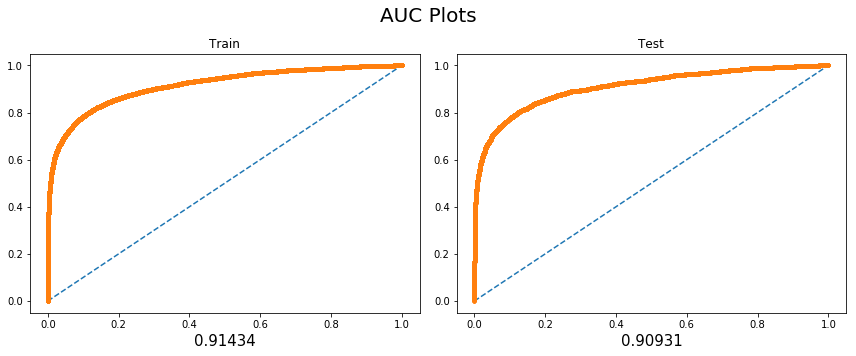

Train-set AUC Score = 0.91434
Test-set AUC Score = 0.90931


In [14]:
auc_plot_score(LightGBM.predict, X_train, X_test, y_train, y_test, dim=1)

In [15]:
lgb_train = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)

params ={
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'verbose': -1,
    'bagging_fraction' : 0.9,
    'pos_bagging_fraction': 0.9,
    'neg_bagging_fraction': 0.3,
    'bagging_freq' : 10
}
gc.collect()

4509

In [16]:
%%time
LightGBM_imb = lgb.train(params,
                train_set=lgb_train,
                )

CPU times: user 54.8 s, sys: 7.32 s, total: 1min 2s
Wall time: 1min 2s


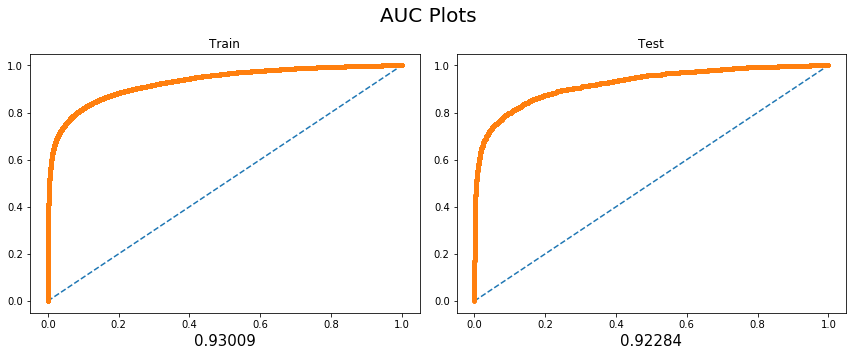

Train-set AUC Score = 0.93009
Test-set AUC Score = 0.92284


In [18]:
auc_plot_score(LightGBM_imb.predict, X_train, X_test, y_train, y_test, dim=1)

### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

RandomForest = RandomForestClassifier(bootstrap=True, oob_score=False, random_state = 42, class_weight={0:1, 1:30})
gc.collect()

4517

In [20]:
%%time
RandomForest.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 16s, sys: 3 s, total: 1min 19s
Wall time: 1min 19s


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 30},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

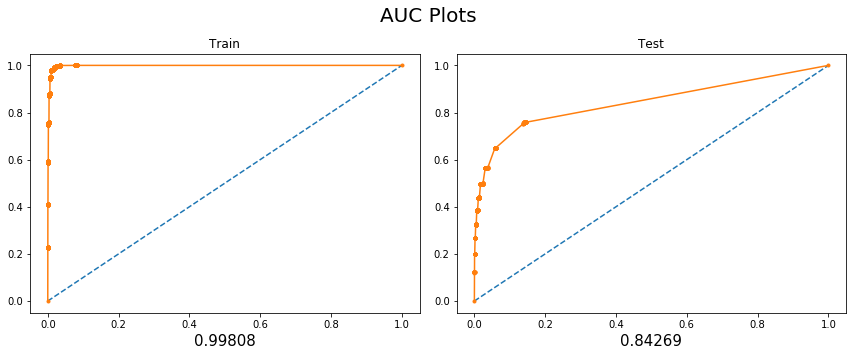

Train-set AUC Score = 0.99808
Test-set AUC Score = 0.84269


In [21]:
auc_plot_score(RandomForest.predict_proba, X_train, X_test, y_train, y_test)

### Neural Networks

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [23]:
NeuralNetwork = Sequential()

NeuralNetwork.add(Dense(units=10, activation='tanh', kernel_initializer='uniform', input_dim=X_train.shape[1]))
NeuralNetwork.add(Dense(units=10, activation='tanh'))
NeuralNetwork.add(Dense(units=10, activation='tanh'))
NeuralNetwork.add(Dense(units=10, activation='tanh'))
NeuralNetwork.add(Dense(units=10, activation='tanh'))
NeuralNetwork.add(Dense(units=2, activation='sigmoid'))

adm = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

NeuralNetwork.compile(optimizer = adm, loss = 'sparse_categorical_crossentropy') # , metrics=['sparse_categorical_accuracy'])
gc.collect()

22

In [24]:
%%time
NeuralNetwork.fit(X_train,np.array(y_train), batch_size=128, epochs=10)

Epoch 1/10
530189/530189 [==============================] - 56s 106us/step - loss: 0.1303
Epoch 2/10
530189/530189 [==============================] - 55s 103us/step - loss: 0.1230
Epoch 3/10
530189/530189 [==============================] - 55s 103us/step - loss: 0.1217
Epoch 4/10
530189/530189 [==============================] - 54s 102us/step - loss: 0.1192
Epoch 5/10
530189/530189 [==============================] - 57s 108us/step - loss: 0.1225
Epoch 6/10
530189/530189 [==============================] - 55s 103us/step - loss: 0.1240
Epoch 7/10
530189/530189 [==============================] - 56s 105us/step - loss: 0.1228
Epoch 8/10
530189/530189 [==============================] - 55s 103us/step - loss: 0.1211
Epoch 9/10
530189/530189 [==============================] - 55s 103us/step - loss: 0.1225
Epoch 10/10
530189/530189 [==============================] - 54s 101us/step - loss: 0.1231
CPU times: user 10min 42s, sys: 54.5 s, total: 11min 36s
Wall time: 9min 12s


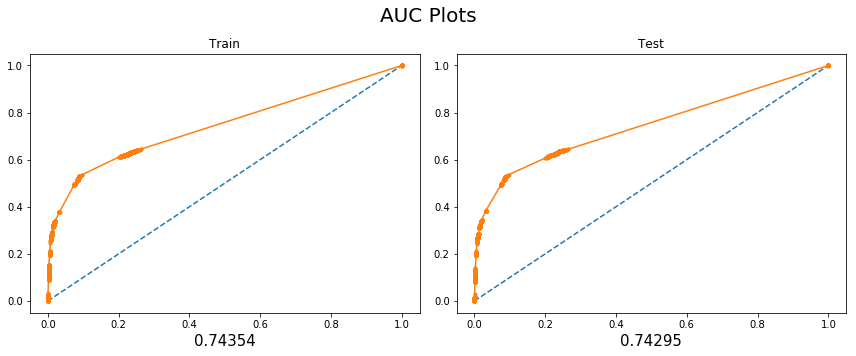

Train-set AUC Score = 0.74354
Test-set AUC Score = 0.74295


In [25]:
auc_plot_score(NeuralNetwork.predict_proba, X_train, X_test, y_train, y_test)

In [26]:
NeuralNetwork_complex = Sequential()

NeuralNetwork_complex.add(Dense(units=1000, activation='tanh', kernel_initializer='uniform', input_dim=X_train.shape[1]))
NeuralNetwork_complex.add(Dense(units=1000, activation='tanh'))
NeuralNetwork_complex.add(Dense(units=500, activation='tanh'))
NeuralNetwork_complex.add(Dense(units=100, activation='tanh'))
NeuralNetwork_complex.add(Dense(units=2, activation='sigmoid'))

ada = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

NeuralNetwork_complex.compile(optimizer = ada, loss = 'sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
gc.collect()

4503

In [27]:
%%time
NeuralNetwork_complex.fit(X_train,np.array(y_train), batch_size=128, epochs=5)

Epoch 1/5
530189/530189 [==============================] - 241s 455us/step - loss: 0.1162 - sparse_categorical_accuracy: 0.9701
Epoch 2/5
530189/530189 [==============================] - 243s 458us/step - loss: 0.1117 - sparse_categorical_accuracy: 0.9713
Epoch 3/5
530189/530189 [==============================] - 241s 454us/step - loss: 0.1111 - sparse_categorical_accuracy: 0.9717
Epoch 4/5
530189/530189 [==============================] - 241s 454us/step - loss: 0.1107 - sparse_categorical_accuracy: 0.9718
Epoch 5/5
530189/530189 [==============================] - 242s 457us/step - loss: 0.1103 - sparse_categorical_accuracy: 0.9719
CPU times: user 50min 31s, sys: 11min 36s, total: 1h 2min 7s
Wall time: 20min 11s


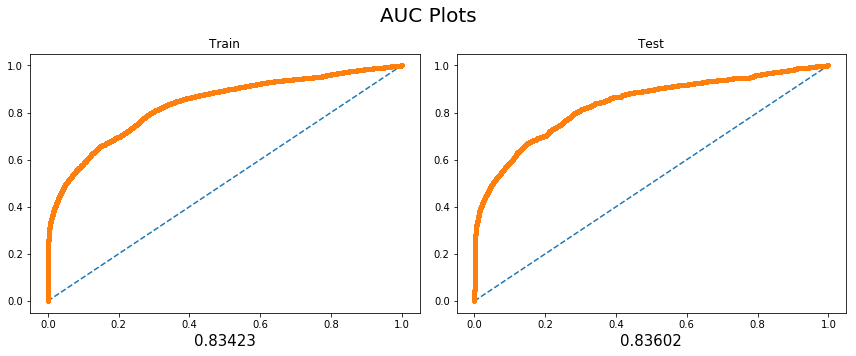

Train-set AUC Score = 0.83423
Test-set AUC Score = 0.83602


In [28]:
auc_plot_score(NeuralNetwork_complex.predict_proba, X_train, X_test, y_train, y_test)

### Takeaways

* XGBoost 
    * XGB surprisingly is able to learn well the pattern even with the dirty model and to generalize it to test set. So it can be considered as a promising method for much better results
    * On the other hand, it takes too long to fit trainin set. It could be hard to check any improvements in the dataset, in the next chapters
* LigthGBM
    * LGBM also performs pretty well. Maybe, it did not get as high as XGB but it make a significant difference in running time.
* Random Forest
    * It learns too well in such a way that it memorize the train-set. The perfect results of training-set significantly decreases in test-set. It obviously suffer from high variance. It could be possible to fix this problem in return of effort. 
* Neural Networks
    * The results they gave does not satisfy. Also it does not take short time.
    * The more meaningful features and better hyperparameter tuning might dramaticly increase the performance. Therefore, it deserves another chance at the end of the project.
    
It is worth to consider LightGBM as a reference method since it is a promising and computationally cheaper method.